# 畫出每個 Block 後的 feature distribution

/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/pytorchcv/models/model_store.py:801: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.

unit: EffiDwsConvUnit(
  (dw_conv): ConvBlock(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activ): Swish()
  )
  (se): SEBlock(
    (pool): AdaptiveAvgPool2d(output_size=1)
    (conv1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
    (activ): Swish()
    (conv2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
    (sigmoid): Sigmoid()
  )
  (pw_conv): ConvBlock(
    (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
unit: EffiInvResUnit(
  (conv1): ConvBlock(
    (conv): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activ): Swish()
  )
  (conv2): ConvBlock(
    (conv): Conv2d(96, 96, kernel_size=(3, 3), strid

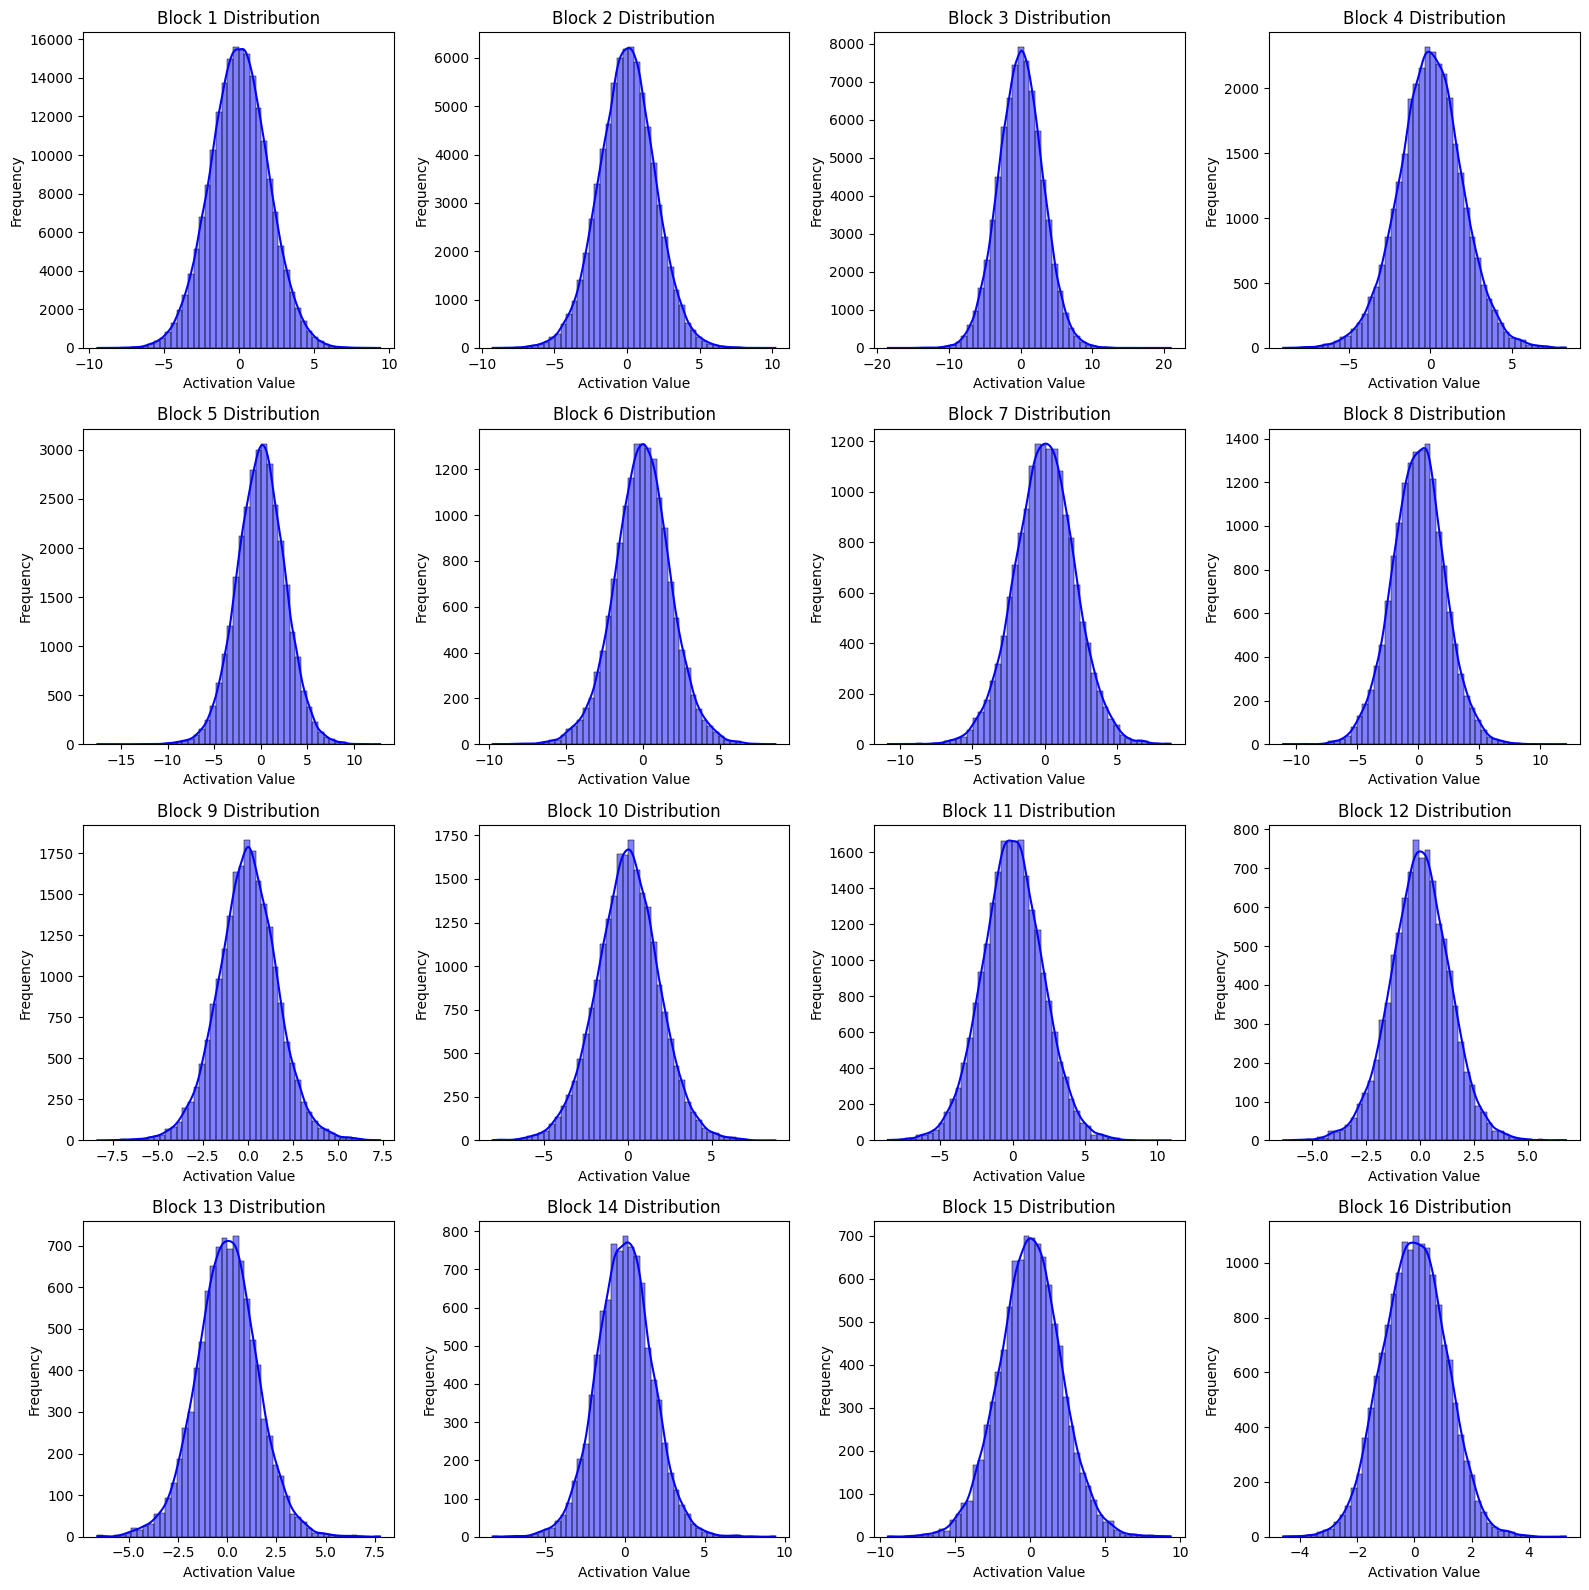

In [5]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pytorchcv.model_provider import get_model as ptcv_get_model 

# 如果想要使用預訓練權重，可以傳入 weights 參數
base_model = ptcv_get_model("efficientnet_b0", pretrained=True)
finetuned_weights_path = "/ssd5/Roy/BlockPruning/paper2025/ff++c23_20250219_1054_results_ff++c23_EFB0_test_auc_5epoch/checkpoints/ff++c23_EFB0_epoch=1-train_acc=0.99-val_acc=0.93.ckpt"
checkpoint = torch.load(finetuned_weights_path)  # 使用 torch.load 讀取檔案
base_model.load_state_dict(checkpoint, strict=False)  # 加載權重字典

# 用來存儲各層輸出的列表
activations = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn(module, input, output):
    activations.append(output)

# 設置鉤子，將鉤子添加到每個 stage 和 unit
hooks = []

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 遍歷所有 stages 和 units，根據判斷註冊鉤子
for stage_idx, stage in enumerate(base_model.features):
    if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
        # print("stage:",stage)
        for unit_idx, unit in enumerate(stage):
            if has_children(unit):
                hook = unit.register_forward_hook(hook_fn)
                hooks.append(hook)
                print("unit:",unit)

print(len(hooks))

# 隨機生成輸入，形狀為 (1, 3, 224, 224)
input_tensor = torch.randn(1, 3, 224, 224)

# 前向傳遞，這將觸發鉤子
base_model(input_tensor)

# 繪製每個 block 的數據分佈圖（直方圖）
fig, axes = plt.subplots(4, 4, figsize=(16, 16))  # 設置 8x4 子圖來顯示 32 個直方圖
axes = axes.flatten()

# 遍歷每個 block 的激活並繪製分佈圖
for i in range(min(16, len(activations))):  # 確保最多繪製 32 張圖
    activation = activations[i].cpu().detach().numpy()  # 取得激活並轉換為 numpy 格式
    flattened_activation = activation.flatten()  # 展平為一維數據
    
    # 繪製數據分佈，使用 seaborn 畫出密度圖
    sns.histplot(flattened_activation, kde=True, ax=axes[i], color='blue', bins=50)
    axes[i].set_title(f'Block {i+1} Distribution')
    axes[i].set_xlabel('Activation Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 釋放鉤子
for hook in hooks:
    hook.remove()



# 畫出每個 Block 後的 feature distribution (Pretrain v.s. Finetune)

/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/pytorchcv/models/model_store.py:801: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.

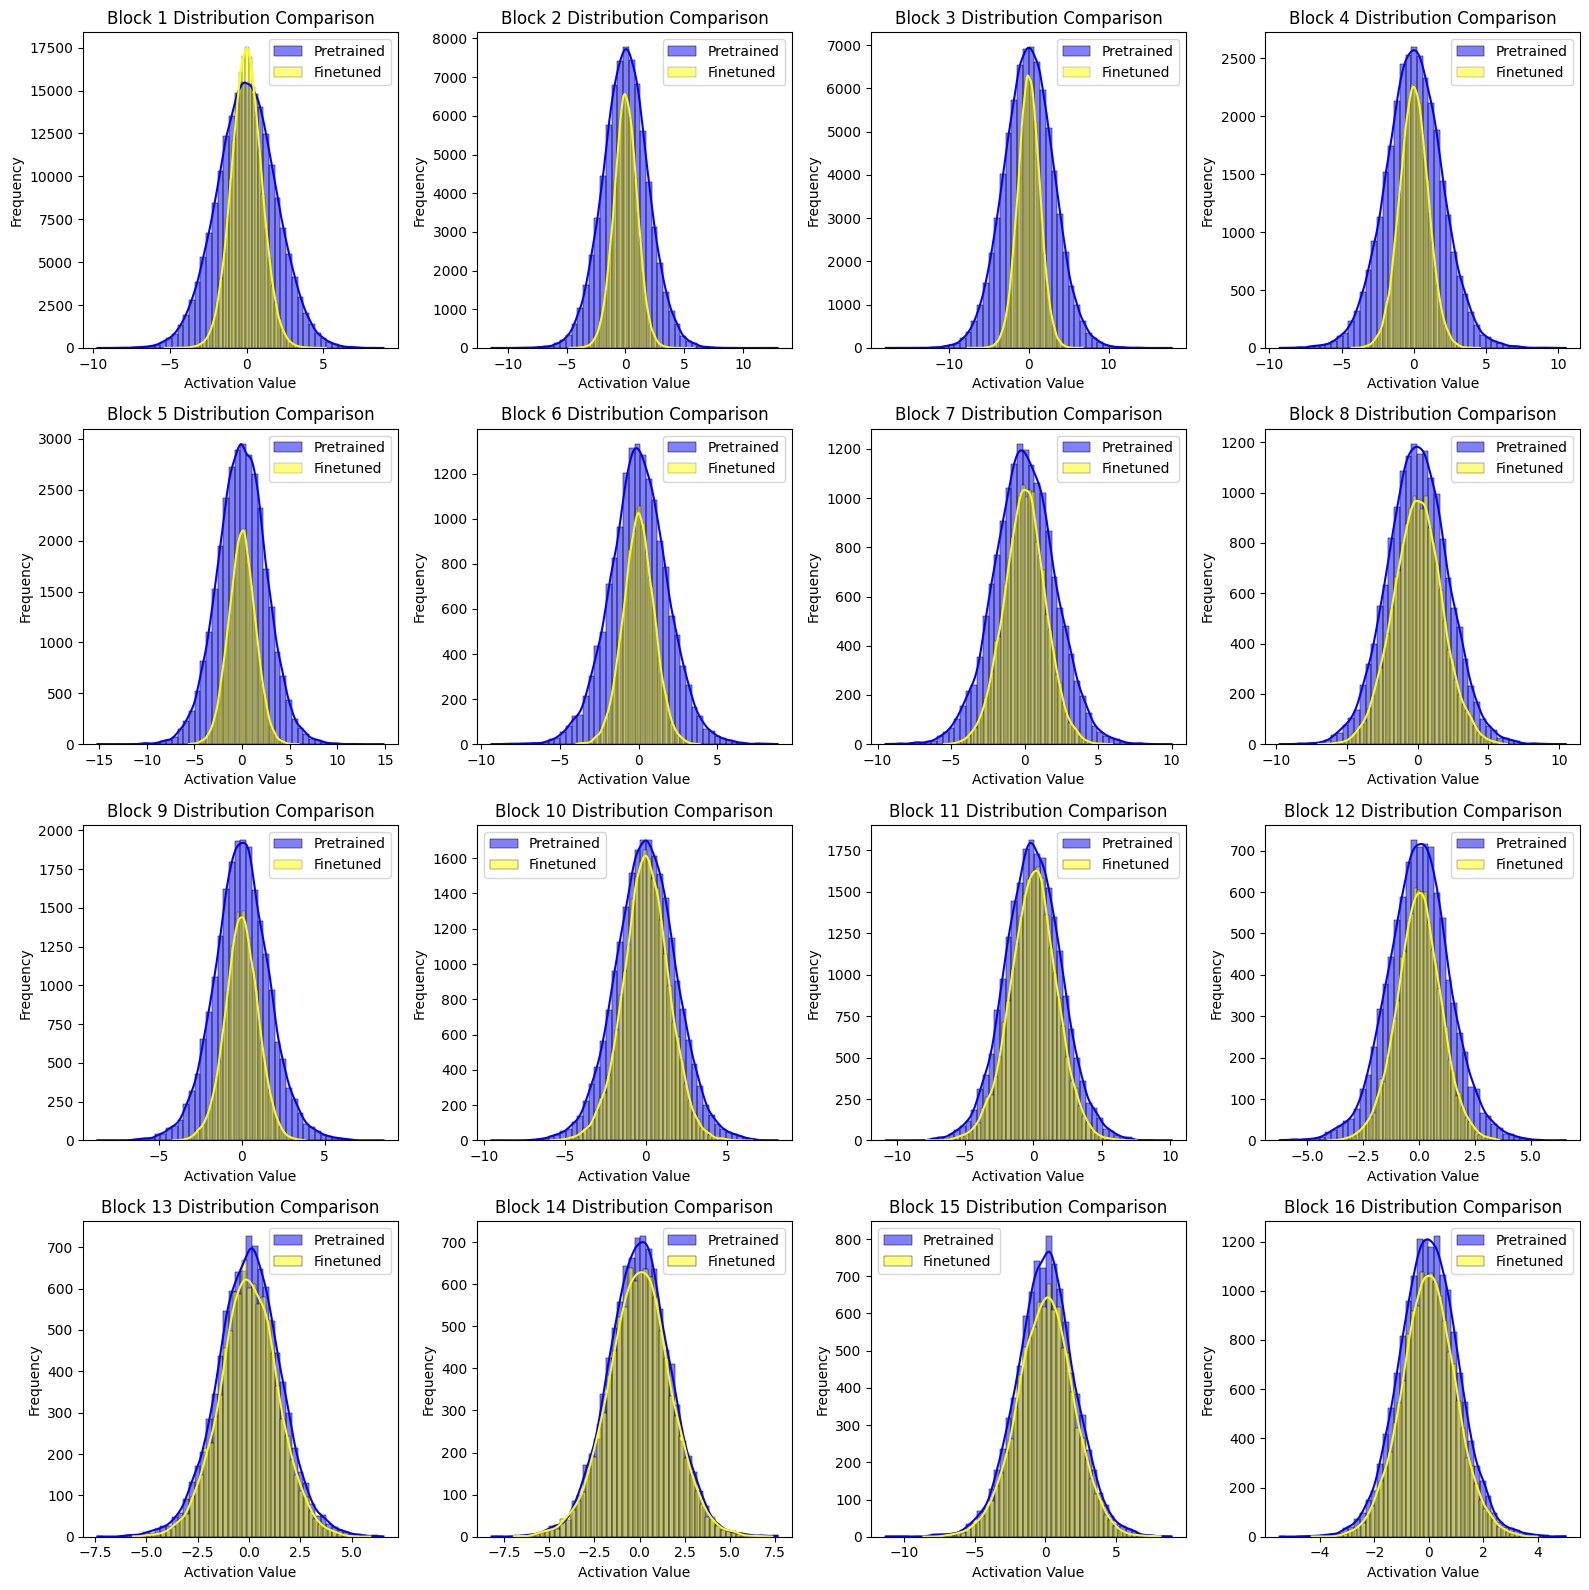

In [6]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pytorchcv.model_provider import get_model as ptcv_get_model

# 用來存儲層輸出的列表
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output)

def hook_fn_finetuned(module, input, output):
    activations_finetuned.append(output)

# 設置鉤子，將鉤子添加到每個 unit（block）
hooks_pretrained = []
hooks_finetuned = []

# 定義一個函數來加載權重並獲取分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 清空之前的激活
    activations_pretrained.clear()

    # 如果有自訓練權重，則加載它們
    if weights:
        checkpoint = torch.load(weights)
        model.load_state_dict(checkpoint['state_dict'], strict=False)

    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.features):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                hook = unit.register_forward_hook(hook_fn)
                hooks.append(hook)
    
    # 隨機生成輸入，形狀為 (1, 3, 224, 224)
    input_tensor = torch.randn(1, 3, 224, 224)

    # 前向傳遞，這將觸發鉤子
    model(input_tensor)

    # 釋放鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    model = ptcv_get_model("efficientnet_b0", pretrained=True)
    return model

# 自訓練權重的模型
def load_finetuned_model(finetuned_weights_path):
    model = ptcv_get_model("efficientnet_b0", pretrained=False)  # 預訓練設置為 False
    # 加載自訓練權重文件並加載權重
    checkpoint = torch.load(finetuned_weights_path)  # 使用 torch.load 讀取檔案
    model.load_state_dict(checkpoint['state_dict'], strict=False)  # 加載權重字典
    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)  # 預訓練權重

activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

# 自訓練權重的路徑
finetuned_weights_path = '/ssd5/Roy/BlockPruning/paper2025/ff++c23_20250219_1054_results_ff++c23_EFB0_test_auc_5epoch/checkpoints/ff++c23_EFB0_epoch=1-train_acc=0.99-val_acc=0.93.ckpt'

# 獲取自訓練權重的激活
activations_finetuned.clear()
finetuned_model = load_finetuned_model(finetuned_weights_path)
get_activations_from_model(finetuned_model, hook_fn_finetuned, hooks_finetuned, finetuned_weights_path)

# 繪製每個 block 的數據分佈圖（直方圖）並比較兩種權重
fig, axes = plt.subplots(4, 4, figsize=(16, 16))  # 設置 8x4 子圖來顯示 32 個直方圖
axes = axes.flatten()

# 遍歷每個 block 的激活並繪製分佈圖
num_plots = min(16, len(activations_pretrained_copy), len(activations_finetuned))

for i in range(num_plots):  
    activation_pretrained = activations_pretrained_copy[i].cpu().detach().numpy()  # 取得預訓練激活並轉換為 numpy 格式
    flattened_activation_pretrained = activation_pretrained.flatten()  # 展平為一維數據
    
    activation_finetuned = activations_finetuned[i].cpu().detach().numpy()  # 取得自訓練激活並轉換為 numpy 格式
    flattened_activation_finetuned = activation_finetuned.flatten()  # 展平為一維數據

    # 繪製數據分佈，使用 seaborn 畫出密度圖
    sns.histplot(flattened_activation_pretrained, kde=True, ax=axes[i], color='blue', bins=50, label="Pretrained")
    sns.histplot(flattened_activation_finetuned, kde=True, ax=axes[i], color='yellow', bins=50, label="Finetuned")
    axes[i].set_title(f'Block {i+1} Distribution Comparison')
    axes[i].set_xlabel('Activation Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()


# 計算平均數和標準差

In [7]:
import torch
import numpy as np
import pandas as pd
from pytorchcv.model_provider import get_model as ptcv_get_model

# 用來存儲層輸出的列表
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output)

def hook_fn_finetuned(module, input, output):
    activations_finetuned.append(output)

# 設置鉤子，將鉤子添加到每個 unit（block）
hooks_pretrained = []
hooks_finetuned = []

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 清空之前的激活
    activations_pretrained.clear()

    # 如果有自訓練權重，則加載它們
    if weights:
        checkpoint = torch.load(weights)
        model.load_state_dict(checkpoint['state_dict'], strict=False)

    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.features):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                hook = unit.register_forward_hook(hook_fn)
                hooks.append(hook)
    
    # 隨機生成輸入，形狀為 (1, 3, 224, 224)
    input_tensor = torch.randn(1, 3, 224, 224)

    # 前向傳遞，這將觸發鉤子
    model(input_tensor)

    # 釋放鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    model = ptcv_get_model("efficientnet_b0", pretrained=True)
    return model

# 自訓練權重的模型
def load_finetuned_model(finetuned_weights_path):
    model = ptcv_get_model("efficientnet_b0", pretrained=False)  # 預訓練設置為 False
    # 加載自訓練權重文件並加載權重
    checkpoint = torch.load(finetuned_weights_path)  # 使用 torch.load 讀取檔案
    model.load_state_dict(checkpoint['state_dict'], strict=False)  # 加載權重字典
    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)  # 預訓練權重

activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

# 自訓練權重的路徑
finetuned_weights_path = '/ssd5/Roy/BlockPruning/paper2025/ff++c23_20250219_1054_results_ff++c23_EFB0_test_auc_5epoch/checkpoints/ff++c23_EFB0_epoch=1-train_acc=0.99-val_acc=0.93.ckpt'

# 獲取自訓練權重的激活
activations_finetuned.clear()
finetuned_model = load_finetuned_model(finetuned_weights_path)
get_activations_from_model(finetuned_model, hook_fn_finetuned, hooks_finetuned, finetuned_weights_path)

# 統計信息
stats = []

num_plots = min(16, len(activations_pretrained_copy), len(activations_finetuned))

for i in range(num_plots):  
    # 取得預訓練激活並轉換為 numpy 格式
    activation_pretrained = activations_pretrained_copy[i].cpu().detach().numpy()
    flattened_activation_pretrained = activation_pretrained.flatten()
    
    # 取得自訓練激活並轉換為 numpy 格式
    activation_finetuned = activations_finetuned[i].cpu().detach().numpy()
    flattened_activation_finetuned = activation_finetuned.flatten()

    # 計算均值和標準差
    mean_pretrained = np.mean(flattened_activation_pretrained)
    std_pretrained = np.std(flattened_activation_pretrained)
    
    mean_finetuned = np.mean(flattened_activation_finetuned)
    std_finetuned = np.std(flattened_activation_finetuned)

    # 獲取輸出形狀
    output_shape = activation_pretrained.shape

    # 存儲統計信息
    stats.append([i+1, output_shape, mean_pretrained, std_pretrained, mean_finetuned, std_finetuned])

# 創建 DataFrame 並顯示
columns = ['block_index', 'output shape', 'mean of pretrained', 'std of pretrained', 'mean of finetuned', 'std of finetuned']
df_stats = pd.DataFrame(stats, columns=columns)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Activation Statistics", dataframe=df_stats)  # 顯示數據表格

df_stats  # 顯示表格的前幾行以便查看



/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/pytorchcv/models/model_store.py:801: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.

,block_index,output shape,mean of pretrained,std of pretrained,mean of finetuned,std of finetuned
0,1,"(1, 16, 112, 112)",9.088188e-07,1.948273,-2.508869e-09,0.999971
1,2,"(1, 24, 56, 56)",-2.372287e-04,1.944616,1.165737e-09,0.999969
2,3,"(1, 24, 56, 56)",-6.050756e-04,3.129096,2.230106e-09,1.411877
3,4,"(1, 40, 28, 28)",-1.589616e-04,1.982307,-7.906739e-10,0.999969
4,5,"(1, 40, 28, 28)",-3.049794e-04,2.594104,-3.223517e-09,1.423063
5,6,"(1, 80, 14, 14)",1.141818e-05,1.854320,-1.246832e-09,0.999969
6,7,"(1, 80, 14, 14)",2.429929e-05,2.103153,-1.946274e-09,1.412579
7,8,"(1, 80, 14, 14)",3.942999e-05,2.170321,-2.554485e-09,1.732718
8,9,"(1, 112, 14, 14)",1.293951e-05,1.674806,9.123160e-10,0.999969
9,10,"(1, 112, 14, 14)",2.838050e-05,1.877461,8.254288e-10,1.405167


# 統計方法 M-W Test & KS Test

In [9]:
import torch
import numpy as np
import pandas as pd
from pytorchcv.model_provider import get_model as ptcv_get_model
import torchvision.models as models
from scipy.stats import ttest_ind

import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)  # 保證所有操作可重現
set_seed(5)  # 設定固定種子

# 設定 device 為 GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# 用來存儲層輸出的列表（轉移到 CPU 以節省 GPU 記憶體）
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    # 將 output detach、clone 並移到 CPU（避免持續佔用 GPU 記憶體）
    activations_pretrained.append(output.detach().clone().cpu())

def hook_fn_finetuned(module, input, output):
    activations_finetuned.append(output.detach().clone().cpu())

# 設置鉤子列表
hooks_pretrained = []
hooks_finetuned = []

import torchvision.transforms as T
from PIL import Image
def read_image(path):
    image = Image.open(path).convert('RGB')
    image = T.Compose([
        T.Resize(224 + 224// 8, interpolation=T.InterpolationMode.BILINEAR),
        T.CenterCrop(224),
        T.ToTensor(),
        # T.Normalize(mean=self.norm_mean, std=self.norm_std),
    ])(image)
    return image

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取激活分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 根據 hook_fn 判斷要清空哪個全域列表
    if hook_fn == hook_fn_pretrained:
        activations_pretrained.clear()
    elif hook_fn == hook_fn_finetuned:
        activations_finetuned.clear()
    
    # 如果有權重檔案，則加載它們
    if weights:
        checkpoint = torch.load(weights, weights_only=True)
        model.load_state_dict(checkpoint['state_dict'], strict=False)
    
    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.features):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                hook = unit.register_forward_hook(hook_fn)
                hooks.append(hook)
    print(len(hooks))
    
    # 生成輸入 tensor，並將其放到 device 上
    input_tensor = torch.randn(1, 3, 224, 224, device=device)
    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Real_youtube/000/000.png'
    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Deepfakes/000_003/000.png'
    # image = read_image(path).to(device)
    # image = image.unsqueeze(0)
    # print(image.shape)
    # model(image)
    model(input_tensor)
    
    # 移除所有鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    model = ptcv_get_model("efficientnet_b0", pretrained=True)
    return model

# 自訓練權重的模型
def load_finetuned_model(finetuned_weights_path):
    model = ptcv_get_model("efficientnet_b0", pretrained=False)  # 預訓練設置為 False
    # 加載自訓練權重文件並加載權重
    checkpoint = torch.load(finetuned_weights_path)  # 使用 torch.load 讀取檔案
    model.load_state_dict(checkpoint['state_dict'], strict=False)  # 加載權重字典
    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

# 自訓練權重的路徑（根據你的路徑設定）
finetuned_weights_path = '/ssd5/Roy/BlockPruning/paper2025/ff++c23_20250219_1054_results_ff++c23_EFB0_test_auc_5epoch/checkpoints/ff++c23_EFB0_epoch=1-train_acc=0.99-val_acc=0.93.ckpt'
activations_finetuned.clear()
finetuned_model = load_finetuned_model(finetuned_weights_path)
get_activations_from_model(finetuned_model, hook_fn_finetuned, hooks_finetuned, finetuned_weights_path)

from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

rows = []
n = min(len(activations_pretrained_copy), len(activations_finetuned))
for i in range(1, n):
    # Pretrained 模型
    act_before_pre = activations_pretrained_copy[i-1].numpy().flatten()
    act_after_pre  = activations_pretrained_copy[i].numpy().flatten()

    act_before_pre = remove_outliers(act_before_pre)
    act_after_pre = remove_outliers(act_after_pre)

    # Mannwhitneyu
    # u_stat_pre, p_val_pre = mannwhitneyu(act_before_pre, act_after_pre, alternative='two-sided')

    # KS
    u_stat_pre, p_val_pre = ks_2samp(act_before_pre, act_after_pre)
    sig_pre = "*" if p_val_pre < 0.05 else ""
    mean_pre = np.mean(act_after_pre)
    std_pre = np.std(act_after_pre)
    
    # Finetuned 模型
    act_before_fine = activations_finetuned[i-1].numpy().flatten()
    act_after_fine  = activations_finetuned[i].numpy().flatten()

    act_before_fine = remove_outliers(act_before_fine)
    act_after_fine = remove_outliers(act_after_fine)

    # Mannwhitneyu
    # u_stat_fine, p_val_fine = mannwhitneyu(act_before_fine, act_after_fine, alternative='two-sided')

    # KS
    u_stat_fine, p_val_fine = ks_2samp(act_before_fine, act_after_fine)
    sig_fine = "*" if p_val_fine < 0.05 else ""
    mean_fine = np.mean(act_after_fine)
    std_fine = np.std(act_after_fine)

    # 使用 pretrained 模型當前 block 的輸出形狀作為參考
    output_shape = activations_pretrained_copy[i].shape
    
    rows.append([i, output_shape, mean_pre, std_pre, sig_pre, mean_fine, std_fine, sig_fine, p_val_fine])

# 建立 DataFrame
columns = ['block_index', 
           'output shape', 
           'mean of pretrained', 'std of pretrained', 'sig of pretrained',
           'mean of finetuned', 'std of finetuned', 'sig of finetuned', 'p_val_fine']
df_stats = pd.DataFrame(rows, columns=columns)

display(df_stats.style.hide(axis="index"))



/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/pytorchcv/models/model_store.py:801: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.

16


/tmp/ipykernel_2638827/2889976292.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(finetuned_weights_path)  # 使用 torch.load 讀取檔案


16


block_index,output shape,mean of pretrained,std of pretrained,sig of pretrained,mean of finetuned,std of finetuned,sig of finetuned,p_val_fine
1,"torch.Size([1, 24, 56, 56])",0.002341,1.849046,,0.000992,0.940445,,0.155691
2,"torch.Size([1, 24, 56, 56])",-0.006845,2.980114,*,-0.001664,1.348980,*,0.000000
3,"torch.Size([1, 40, 28, 28])",0.003712,1.866098,*,-0.000549,0.959141,*,0.000000
4,"torch.Size([1, 40, 28, 28])",0.001758,2.449442,*,0.001295,1.354322,*,0.000000
5,"torch.Size([1, 80, 14, 14])",0.002493,1.719504,*,0.001121,0.950049,*,0.000000
6,"torch.Size([1, 80, 14, 14])",0.004796,1.990687,*,-0.003086,1.348684,*,0.000000
7,"torch.Size([1, 80, 14, 14])",-0.005334,2.068655,,0.001648,1.641326,*,0.000000
8,"torch.Size([1, 112, 14, 14])",-0.001859,1.553483,*,0.002935,0.948382,*,0.000000
9,"torch.Size([1, 112, 14, 14])",-0.001063,1.776638,*,0.005698,1.331754,*,0.000000
10,"torch.Size([1, 112, 14, 14])",-0.003958,2.005432,*,0.000099,1.625684,*,0.000000


# 距離方法 EMD

In [17]:
import torch
import numpy as np
import pandas as pd
import torchvision.models as models
from scipy.stats import wasserstein_distance  # 用於計算 EMD
import random
from pytorchcv.model_provider import get_model as ptcv_get_model

# 設定隨機種子，確保可重現性
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seed(5)

# 設定 device 為 CPU
device = torch.device("cpu")

# 用來存儲層輸出的列表
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output.detach().clone().cpu())

def hook_fn_finetuned(module, input, output):
    activations_finetuned.append(output.detach().clone().cpu())

# 設置鉤子列表
hooks_pretrained = []
hooks_finetuned = []

# 判斷模組是否有子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義函數來加載權重並獲取激活分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 清空對應的激活紀錄
    if hook_fn == hook_fn_pretrained:
        activations_pretrained.clear()
    elif hook_fn == hook_fn_finetuned:
        activations_finetuned.clear()

    # 如果有權重檔案，則加載它們
    if weights:
        checkpoint = torch.load(weights, weights_only=True, map_location=device)
        model.load_state_dict(checkpoint['state_dict'], strict=False)

    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.features):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                hook = unit.register_forward_hook(hook_fn)
                hooks.append(hook)

    # 測試輸入，使用隨機 Tensor
    input_tensor = torch.randn(1, 3, 224, 224, device=device)
    model(input_tensor)

    # 移除所有鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    model = ptcv_get_model("efficientnet_b0", pretrained=True)
    return model

# 自訓練權重的模型
def load_finetuned_model(finetuned_weights_path):
    model = ptcv_get_model("efficientnet_b0", pretrained=False)  # 預訓練設置為 False
    # 加載自訓練權重文件並加載權重
    checkpoint = torch.load(finetuned_weights_path)  # 使用 torch.load 讀取檔案
    model.load_state_dict(checkpoint['state_dict'], strict=False)  # 加載權重字典
    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

# 自訓練權重的路徑
finetuned_weights_path = '/ssd5/Roy/BlockPruning/paper2025/ff++c23_20250219_1054_results_ff++c23_EFB0_test_auc_5epoch/checkpoints/ff++c23_EFB0_epoch=1-train_acc=0.99-val_acc=0.93.ckpt'
activations_finetuned.clear()
finetuned_model = load_finetuned_model(finetuned_weights_path)
get_activations_from_model(finetuned_model, hook_fn_finetuned, hooks_finetuned, finetuned_weights_path)

# 計算 EMD
def emd_distance(features1, features2):
    return wasserstein_distance(features1.flatten(), features2.flatten())

# 去除離群值
def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

# 記錄結果
rows = []
n = min(len(activations_pretrained_copy), len(activations_finetuned))
for i in range(1, n):
    # Pretrained 模型
    act_before_pre = activations_pretrained_copy[i-1].numpy().flatten()
    act_after_pre  = activations_pretrained_copy[i].numpy().flatten()

    act_before_pre = remove_outliers(act_before_pre)
    act_after_pre = remove_outliers(act_after_pre)

    emd_pre = emd_distance(act_before_pre, act_after_pre)
    mean_pre = np.mean(act_after_pre)
    std_pre = np.std(act_after_pre)
    
    # Finetuned 模型
    act_before_fine = activations_finetuned[i-1].numpy().flatten()
    act_after_fine  = activations_finetuned[i].numpy().flatten()

    act_before_fine = remove_outliers(act_before_fine)
    act_after_fine = remove_outliers(act_after_fine)

    emd_fine = emd_distance(act_before_fine, act_after_fine)
    sig_fine = "*" if emd_fine>0.4 else ""
    mean_fine = np.mean(act_after_fine)
    std_fine = np.std(act_after_fine)

    # 使用 pretrained 模型當前 block 的輸出形狀作為參考
    output_shape = activations_pretrained_copy[i].shape
    
    rows.append([i, output_shape, mean_pre, std_pre, emd_pre, mean_fine, std_fine, emd_fine, sig_fine])

# 建立 DataFrame
columns = ['block_index', 
           'output shape', 
           'mean of pretrained', 'std of pretrained', 'EMD of pretrained',
           'mean of finetuned', 'std of finetuned', 'EMD of finetuned', 'sig_fine']
df_stats = pd.DataFrame(rows, columns=columns)

# 顯示 DataFrame，隱藏 index
display(df_stats.style.hide(axis="index"))


/tmp/ipykernel_2638827/1208551869.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(finetuned_weights_path)  # 使用 torch.load 讀取檔案


block_index,output shape,mean of pretrained,std of pretrained,EMD of pretrained,mean of finetuned,std of finetuned,EMD of finetuned,sig_fine
1,"torch.Size([1, 24, 56, 56])",0.002341,1.849046,0.026172,0.000992,0.940445,0.008066,
2,"torch.Size([1, 24, 56, 56])",-0.006845,2.980114,0.915465,-0.001664,1.348980,0.328864,
3,"torch.Size([1, 40, 28, 28])",0.003712,1.866098,0.904957,-0.000549,0.959141,0.312585,
4,"torch.Size([1, 40, 28, 28])",0.001758,2.449442,0.473607,0.001295,1.354322,0.315933,
5,"torch.Size([1, 80, 14, 14])",0.002493,1.719504,0.599447,0.001121,0.950049,0.323847,
6,"torch.Size([1, 80, 14, 14])",0.004796,1.990687,0.230643,-0.003086,1.348684,0.315955,
7,"torch.Size([1, 80, 14, 14])",-0.005334,2.068655,0.063598,0.001648,1.641326,0.236098,
8,"torch.Size([1, 112, 14, 14])",-0.001859,1.553483,0.420241,0.002935,0.948382,0.553512,*
9,"torch.Size([1, 112, 14, 14])",-0.001063,1.776638,0.185120,0.005698,1.331754,0.304135,
10,"torch.Size([1, 112, 14, 14])",-0.003958,2.005432,0.185044,0.000099,1.625684,0.233844,


In [ ]:
import torch
from pytorchcv.model_provider import get_model as ptcv_get_model 

# 如果想要使用預訓練權重，可以傳入 weights 參數
base_model = ptcv_get_model("efficientnet_b0", pretrained=True)
finetuned_weights_path = "/ssd5/Roy/BlockPruning/paper2025/ff++c23_20250219_1054_results_ff++c23_EFB0_test_auc_5epoch/checkpoints/ff++c23_EFB0_epoch=1-train_acc=0.99-val_acc=0.93.ckpt"
checkpoint = torch.load(finetuned_weights_path)  # 使用 torch.load 讀取檔案
base_model.load_state_dict(checkpoint, strict=False)  # 加載權重字典

# 刪除 stage2 的 unit1 和 stage5 的 unit4
del base_model.features.stage2[0]  # stage2 的 unit1
del base_model.features.stage5[3]  # stage5 的 unit4


# # 取得原本的 Conv2d 層
# old_conv = base_model.features.stage2[0].conv1.conv
# # 重新建立一個新的 Conv2d 層，修改 in_channels 為 48，其它參數保持不變
# new_conv = torch.nn.Conv2d(
#     in_channels=16,  # 修改這裡
#     out_channels=old_conv.out_channels,
#     kernel_size=old_conv.kernel_size,
#     stride=old_conv.stride,
#     padding=old_conv.padding,
#     bias=old_conv.bias is not None  # 保持 bias 設定
# )
# # 替換舊的 Conv2d 層
# base_model.features.stage2[0].conv1.conv = new_conv


# 確保模型沒有錯誤
print(base_model)

/tmp/ipykernel_2750922/2039442398.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(finetuned_weights_path)  # 使用 torch.load 讀取檔案


EfficientNet(
  (features): Sequential(
    (init_block): EffiInitBlock(
      (conv): ConvBlock(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): Swish()
      )
    )
    (stage1): Sequential(
      (unit1): EffiDwsConvUnit(
        (dw_conv): ConvBlock(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): Swish()
        )
        (se): SEBlock(
          (pool): AdaptiveAvgPool2d(output_size=1)
          (conv1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (activ): Swish()
          (conv2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (sigmoid): Sigmoid()
        )
        (pw_conv): ConvBlock(
          (conv): Conv2d(32, 16, kernel_

: 

In [1]:
import numpy as np

data = (58.04, 86.73, 86.2)

mean = np.mean(data)
std = np.std(data, ddof=0)  # 母體標準差，若要用樣本標準差就設 ddof=1

print("平均數:", mean)
print("標準差:", std)

平均數: 76.99000000000001
標準差: 13.401420322736941
